In [252]:
import os
import json
import random
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import random

In [301]:
# Precomputed affine matrix file (3x4 matrix for each subject, excluding the homogeneous row), see utils/Localizer_DataAugmentation
gt_affine_path = "/combined_ground_truth_affine.json"

with open(gt_affine_path, 'r') as f:
    gt_affine_dict = json.load(f)

original_subject_ids = ['4102_1', '4102_2', '4105_1', '4105_2', '4107', '4108_1', '4108_2',
    '4109', '4112', '4113', '4115', '4116', '4117', '4118', '4125', '4128', '4130',
    '4133', '4134', '4135', '4139', '4140', '4141', '4143', '4144',
    '4146', '4148', '4149', '4150', '4151', '4204', '4205', '4206', '4207', '4208', '4211_1', 
    '4209', '4210', '4211_2', '4212', '4213'
]

test_subject_ids = ['4209', '4210', '4211_2', '4212', '4213']
train_original_ids = [sid for sid in original_subject_ids if sid not in test_subject_ids]
num_samples = 1000
random_ids = random.sample(range(5000, 6000), num_samples)
new_ids = [f"{i:04d}" for i in random_ids]

localizer_base_path = "/32CH_LOCALIZER_0001/"

class LocalizerDataset(Dataset):
    def __init__(self, subject_ids, base_path, gt_affine_dict):
        self.subject_ids = subject_ids
        self.base_path = base_path
        self.gt_affine_dict = gt_affine_dict

    def __len__(self):
        return len(self.subject_ids)

    def __getitem__(self, idx):
        subject_id = self.subject_ids[idx]
        folder = os.path.join(self.base_path, subject_id)
        files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".nii.gz")])
        imgs = []
        for file in files:
            img = nib.load(file)
            # Convert to RAS coordinate system
            img = nib.as_closest_canonical(img)
            data = img.get_fdata()
            # (Preprocess if image data is 3D)
            if data.ndim == 3 and data.shape[-1] == 1:
                data = np.squeeze(data, axis=-1)
            data = np.abs(data) / 255.0
            imgs.append(data.astype(np.float32))
        # Stack all images (maintaining channel order)
        image_stack = np.stack(imgs, axis=0)
        # Load the precomputed affine matrix from the JSON file (3x4 matrix)
        if subject_id not in self.gt_affine_dict:
            raise ValueError(f"Subject id {subject_id} not found in ground truth affine file.")
        affine_matrix = np.array(self.gt_affine_dict[subject_id], dtype=np.float32)
        return (torch.tensor(image_stack, dtype=torch.float32),
                torch.tensor(affine_matrix, dtype=torch.float32),
                subject_id)  # Also return subject id (used for evaluation)

# Create datasets
train_original_dataset = LocalizerDataset(train_original_ids, localizer_base_path, gt_affine_dict)
train_augmented_dataset = LocalizerDataset(new_ids, localizer_base_path, gt_affine_dict)
test_dataset = LocalizerDataset(test_subject_ids, localizer_base_path, gt_affine_dict)

combined_dataset = ConcatDataset([train_original_dataset, train_augmented_dataset])
total_size = len(combined_dataset)
train_size = int(total_size * 0.85)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=5, shuffle=False)

print("Train dataset size :", train_size)
print("Validation dataset size :", val_size)
print("Test dataset size :", len(test_subject_ids))


Train dataset size : 880
Validation dataset size : 156
Test dataset size : 5


In [283]:
def get_T_torch(P):
    # Create a batch of 4x4 identity matrices for each sample in the batch (B samples)
    B = P.shape[0]
    T = torch.eye(4, device=P.device).unsqueeze(0).repeat(B, 1, 1)
    # Set the translation components for each matrix using the first three elements of P
    T[:, 0, 3] = P[:, 0]
    T[:, 1, 3] = P[:, 1]
    T[:, 2, 3] = P[:, 2]
    return T

def get_R1_torch(P):
    # Batch rotation around the x-axis. This function converts degrees to radians,
    # allowing for gradient computation and GPU execution.
    B = P.shape[0]
    rx = P[:, 3] * (np.pi / 180)
    cos_rx = torch.cos(rx)
    sin_rx = torch.sin(rx)
    R1 = torch.eye(4, device=P.device).unsqueeze(0).repeat(B, 1, 1)
    R1[:, 1, 1] = cos_rx
    R1[:, 1, 2] = sin_rx
    R1[:, 2, 1] = -sin_rx
    R1[:, 2, 2] = cos_rx
    return R1

def get_R2_torch(P):
    # Batch rotation around the y-axis.
    B = P.shape[0]
    ry = P[:, 4] * (np.pi / 180)
    cos_ry = torch.cos(ry)
    sin_ry = torch.sin(ry)
    R2 = torch.eye(4, device=P.device).unsqueeze(0).repeat(B, 1, 1)
    R2[:, 0, 0] = cos_ry
    R2[:, 0, 2] = sin_ry
    R2[:, 2, 0] = -sin_ry
    R2[:, 2, 2] = cos_ry
    return R2

def get_R3_torch(P):
    # Batch rotation around the z-axis.
    B = P.shape[0]
    rz = P[:, 5] * (np.pi / 180)
    cos_rz = torch.cos(rz)
    sin_rz = torch.sin(rz)
    R3 = torch.eye(4, device=P.device).unsqueeze(0).repeat(B, 1, 1)
    R3[:, 0, 0] = cos_rz
    R3[:, 0, 1] = sin_rz
    R3[:, 1, 0] = -sin_rz
    R3[:, 1, 1] = cos_rz
    return R3

def get_Z_torch(P):
    # Batch scaling matrix using the last three elements of P.
    B = P.shape[0]
    Z = torch.eye(4, device=P.device).unsqueeze(0).repeat(B, 1, 1)
    Z[:, 0, 0] = P[:, 6]
    Z[:, 1, 1] = P[:, 7]
    Z[:, 2, 2] = P[:, 8]
    return Z

def compute_affine_torch(P):
    # P: (B, 9) coefficient vector for each sample
    # The conversion to PyTorch allows GPU acceleration and efficient processing of batches,
    # as well as enabling backpropagation through the affine transformation.
    T_mat = get_T_torch(P)
    # Combine rotations: R_total = R3 * R2 * R1 using batch matrix multiplication (torch.bmm)
    R_total = torch.bmm(get_R3_torch(P), torch.bmm(get_R2_torch(P), get_R1_torch(P)))
    Z_mat = get_Z_torch(P)
    # Transpose the total rotation matrix for coordinate system conversion
    R_total_T = R_total.transpose(1, 2)
    A = torch.bmm(torch.bmm(T_mat, R_total_T), Z_mat)
    # Return the 3x4 affine matrix for each sample by excluding the last row
    return A[:, :3, :]


In [284]:
class MultiChannelCNN(nn.Module):
    def __init__(self, out_dim=9):
        super(MultiChannelCNN, self).__init__()
        self.channel_cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2),
        )
        self.concat_cnn = nn.Sequential(
            nn.Conv2d(48, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(16 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, out_dim)
    def forward(self, x):
        sagittal = x[:, 0:1, :, :]
        coronal  = x[:, 1:2, :, :]
        axial    = x[:, 2:3, :, :]
        sag_feat = self.channel_cnn(sagittal)
        cor_feat = self.channel_cnn(coronal)
        ax_feat  = self.channel_cnn(axial)
        concat_feat = torch.cat([sag_feat, cor_feat, ax_feat], dim=1)
        concat_feat = self.concat_cnn(concat_feat)
        concat_feat = concat_feat.view(concat_feat.size(0), -1)
        x = F.relu(self.fc1(concat_feat))
        out = self.fc2(x)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiChannelCNN(out_dim=9).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

num_epochs = 100

In [285]:
from torchsummary import summary
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              80
         LeakyReLU-2          [-1, 8, 512, 512]               0
         MaxPool2d-3          [-1, 8, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           1,168
         LeakyReLU-5         [-1, 16, 256, 256]               0
         MaxPool2d-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 16, 128, 128]           2,320
         LeakyReLU-8         [-1, 16, 128, 128]               0
         MaxPool2d-9           [-1, 16, 64, 64]               0
           Conv2d-10          [-1, 8, 512, 512]              80
        LeakyReLU-11          [-1, 8, 512, 512]               0
        MaxPool2d-12          [-1, 8, 256, 256]               0
           Conv2d-13         [-1, 16, 256, 256]           1,168
        LeakyReLU-14         [-1, 16, 2

In [286]:
def custom_affine_loss(pred_coeff, true_affine):
    # pred_coeff: (B,9), true_affine: (B,3,4) where true_affine is already an affine matrix.
    # Compute the predicted affine matrix from the coefficient vector using the PyTorch version of compute_affine.
    pred_affine = compute_affine_torch(pred_coeff)  # (B,3,4)
    # Calculate Mean Squared Error loss between the predicted and true affine matrices.
    mse_loss = F.mse_loss(pred_affine, true_affine)
    # Calculate Mean Absolute Error loss between the predicted and true affine matrices.
    mae_loss = F.l1_loss(pred_affine, true_affine)
    # Combine the losses, weighting MAE more heavily.
    loss = 0.3 * mse_loss + 0.7 * mae_loss
    return loss


def train_model(model, train_loader, val_loader, optimizer, num_epochs, device, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, gt_params, _ in train_loader:
            images = images.to(device)
            gt_params = gt_params.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # (B, 9) predicted coefficient vector
            loss = custom_affine_loss(outputs, gt_params)
            loss.backward()
            # Clip gradients to prevent exploding gradients and improve stability.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, gt_params, _ in val_loader:
                images = images.to(device)
                gt_params = gt_params.to(device)
                outputs = model(images)
                loss = custom_affine_loss(outputs, gt_params)
                val_running_loss += loss.item() * images.size(0)
        val_loss = val_running_loss / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping check: if validation loss improves, save the state; otherwise, count the no-improve epochs.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_state)
            break

    return best_model_state  # Return the best model state found during training

# Save the best model state after training
best_model_path = "best_model.pth"
best_model_state = train_model(model, train_loader, val_loader, optimizer, num_epochs, device, patience=10)
torch.save(best_model_state, best_model_path)


Epoch 1/100 | Train Loss: 2409.8982 | Val Loss: 748.0537
Epoch 2/100 | Train Loss: 691.7670 | Val Loss: 734.8020
Epoch 3/100 | Train Loss: 683.4745 | Val Loss: 804.7433
Epoch 4/100 | Train Loss: 682.6816 | Val Loss: 842.0937
Epoch 5/100 | Train Loss: 675.4285 | Val Loss: 656.8350
Epoch 6/100 | Train Loss: 564.6709 | Val Loss: 603.1493
Epoch 7/100 | Train Loss: 550.4758 | Val Loss: 476.9023
Epoch 8/100 | Train Loss: 456.4756 | Val Loss: 344.2211
Epoch 9/100 | Train Loss: 257.9316 | Val Loss: 193.4731
Epoch 10/100 | Train Loss: 181.8625 | Val Loss: 239.4854
Epoch 11/100 | Train Loss: 147.3447 | Val Loss: 149.6837
Epoch 12/100 | Train Loss: 120.1968 | Val Loss: 135.5194
Epoch 13/100 | Train Loss: 98.8474 | Val Loss: 88.4683
Epoch 14/100 | Train Loss: 89.6890 | Val Loss: 123.9152
Epoch 15/100 | Train Loss: 83.9638 | Val Loss: 125.5483
Epoch 16/100 | Train Loss: 82.6983 | Val Loss: 70.4336
Epoch 17/100 | Train Loss: 71.8703 | Val Loss: 64.1522
Epoch 18/100 | Train Loss: 60.9201 | Val Loss: 

In [322]:
best_model_path = "best_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

/tmp/ipykernel_4156789/3713287453.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


MultiChannelCNN(
  (channel_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (concat_cnn): Sequential(
    (0): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPo

In [ ]:
import os
import json
import nibabel as nib

import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull
from scipy.ndimage import affine_transform
from scipy.spatial.transform import Rotation as R

from shapely.geometry import Polygon 

Subject 4209: Predicted 3D OBB size (w, h, d): [303.64688 334.66467 298.79434]


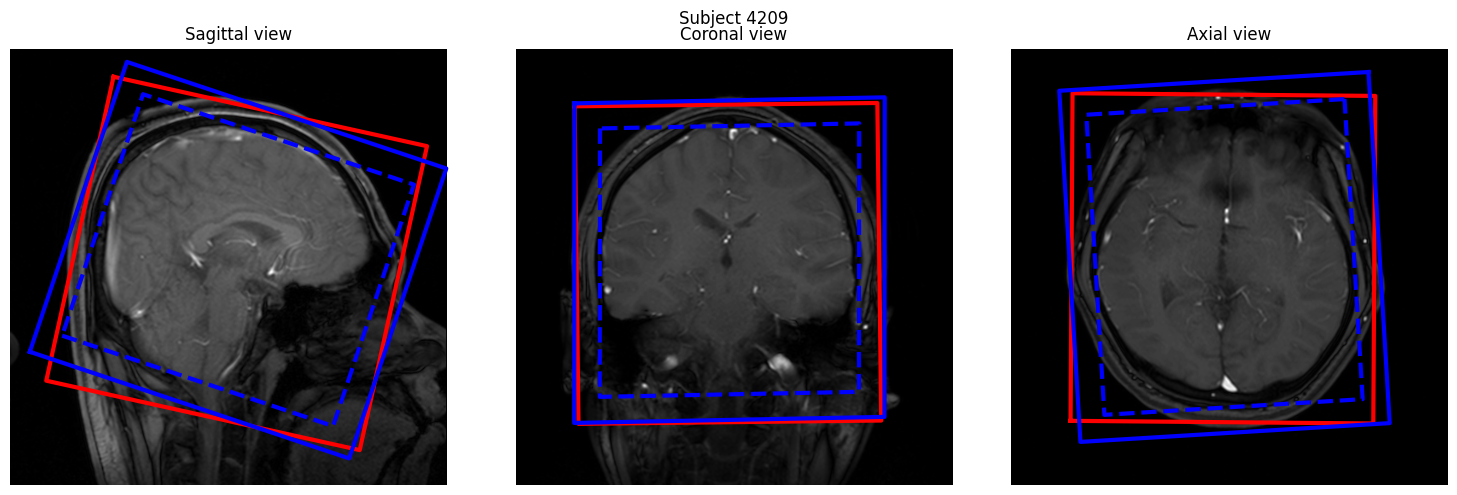

Subject 4210: Predicted 3D OBB size (w, h, d): [293.23236 328.95093 288.54575]


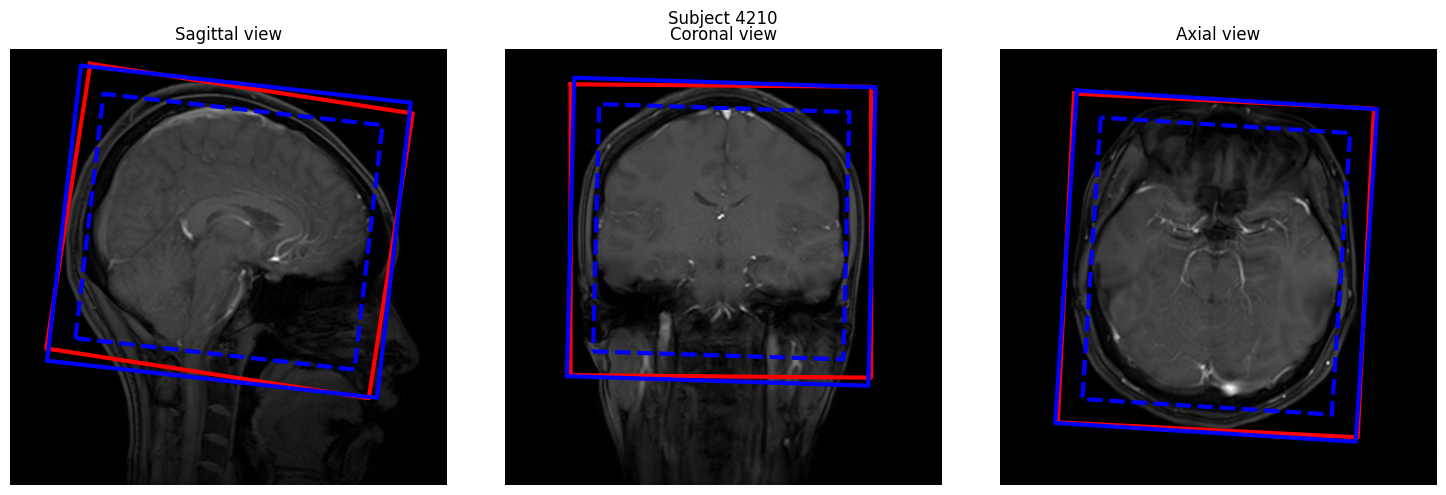

Subject 4211_2: Predicted 3D OBB size (w, h, d): [299.4421  337.08    287.43716]


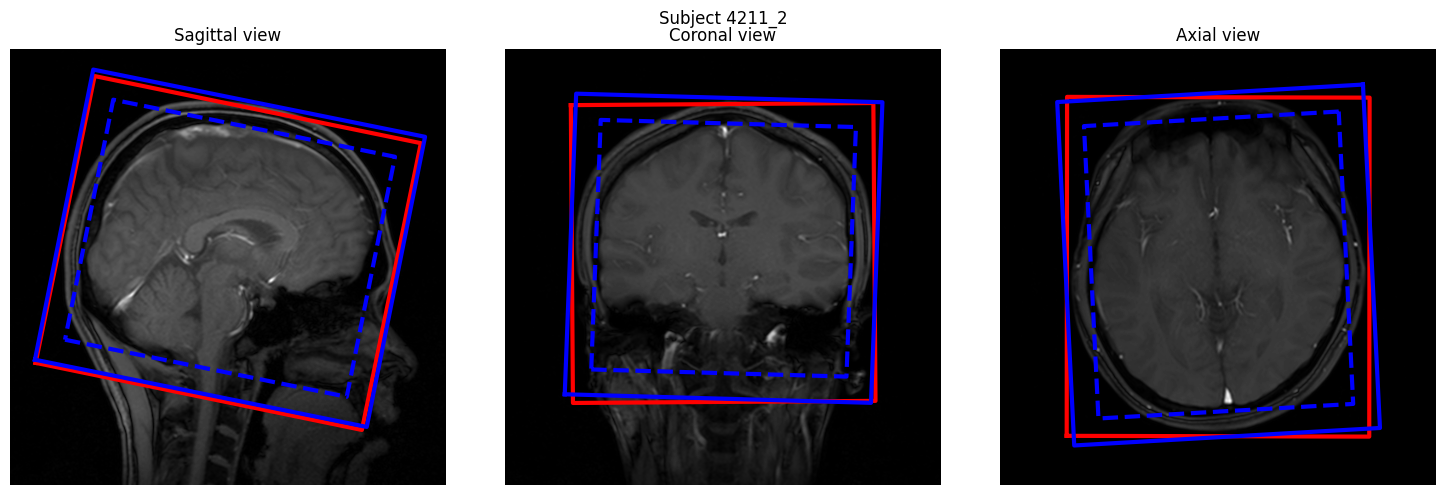

Subject 4212: Predicted 3D OBB size (w, h, d): [288.39267 306.53937 278.30554]


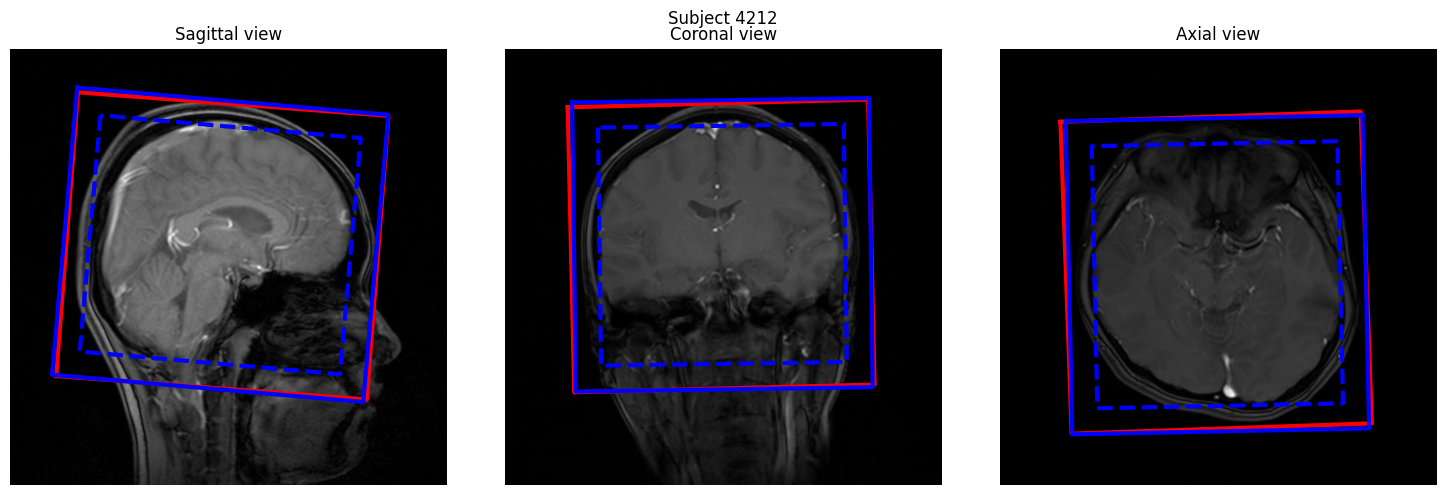

Subject 4213: Predicted 3D OBB size (w, h, d): [312.39087 359.57257 303.1845 ]


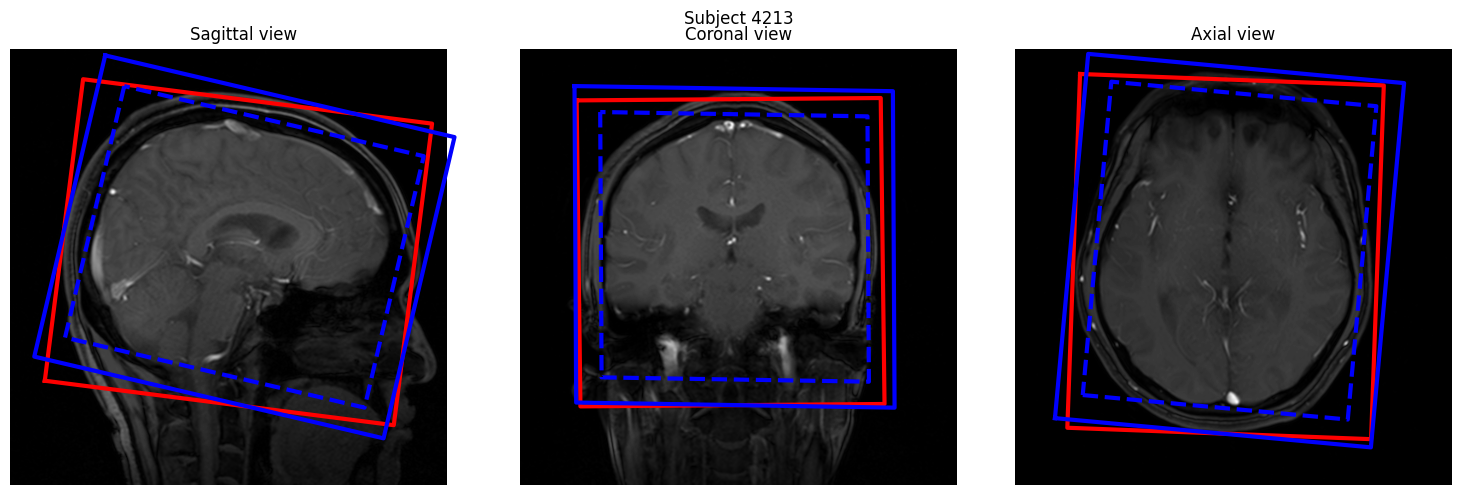

Test Average Loss: 48.9566


In [329]:
########################################
# 1. Define Unit Cube and Edges (Local Coordinate System)
########################################
def get_unit_cube_vertices():
    """Vertices of a unit cube in the local coordinate system (8,3), each coordinate: -0.5 ~ 0.5"""
    return np.array([
        [-0.5, -0.5, -0.5],
        [-0.5, -0.5,  0.5],
        [-0.5,  0.5, -0.5],
        [-0.5,  0.5,  0.5],
        [ 0.5, -0.5, -0.5],
        [ 0.5, -0.5,  0.5],
        [ 0.5,  0.5, -0.5],
        [ 0.5,  0.5,  0.5]
    ], dtype=np.float32)

# 12 edges (each edge is a pair of vertex indices)
CUBE_EDGES = [
    (0,1), (0,2), (0,4),
    (1,3), (1,5),
    (2,3), (2,6),
    (3,7),
    (4,5), (4,6),
    (5,7),
    (6,7)
]

########################################
# 2. RAS Transformation (LPI -> RAS: Invert X and Y signs)
########################################
def convert_to_ras(corners):
    corners_ras = np.copy(corners)
    corners_ras[:,0] = -corners_ras[:,0]
    corners_ras[:,1] = -corners_ras[:,1]
    return corners_ras

########################################
# 3. Affine Transformation and Projection Functions (Same as before)
########################################
def transform_points(pts, affine):
    """Apply the affine transformation (3,4) to pts: (N,3) and return transformed 3D points (N,3)"""
    N = pts.shape[0]
    ones = np.ones((N, 1), dtype=pts.dtype)
    pts_h = np.hstack([pts, ones])
    return (affine @ pts_h.T).T

def project_points(pts_3d, proj_idx):
    """Select two axes (proj_idx: list of 2) from 3D points (N,3) for projection"""
    return pts_3d[:, proj_idx]

########################################
# 4. Function to Compute Intersection Between a Plane and an Edge
########################################
def intersect_edge_with_plane(v1, v2, axis, value):
    diff1 = v1[axis] - value
    diff2 = v2[axis] - value
    # If one point is above and one is below the plane, they intersect
    if diff1 * diff2 < 0:
        t = (value - v1[axis]) / (v2[axis] - v1[axis])
        return v1 + t * (v2 - v1)
    # In case one point is very close to the plane
    if abs(diff1) < 1e-6:
        return v1
    if abs(diff2) < 1e-6:
        return v2
    return None

########################################
# 5. Function to Compute the Intermediate Slice Polygon
########################################
def get_slice_polygon_from_affine(affine, view='sagittal'):
    # Get unit cube vertices (in LPI) and convert to RAS coordinates
    corners = get_unit_cube_vertices()
    corners_ras = convert_to_ras(corners)
    # Transformed 8 points (global coordinates)
    pts = transform_points(corners_ras, affine)  # (8,3)
    # Compute the center (for a symmetric unit cube, center = affine * [0,0,0,1])
    center = affine @ np.array([0,0,0,1], dtype=np.float32)  # (3,)
    
    # Define the plane: select axis and projection dimensions based on the view
    if view == 'sagittal':
        axis = 0  # x = center[0]
        proj_dims = [1,2]  # project y and z
    elif view == 'coronal':
        axis = 1  # y = center[1]
        proj_dims = [0,2]  # project x and z
    elif view == 'axial':
        axis = 2  # z = center[2]
        proj_dims = [0,1]  # project x and y
    else:
        axis = 0
        proj_dims = [1,2]
    
    # Calculate the intersection between each cube edge and the defined plane
    intersections = []
    for e in CUBE_EDGES:
        v1 = pts[e[0]]
        v2 = pts[e[1]]
        p = intersect_edge_with_plane(v1, v2, axis, center[axis])
        if p is not None:
            intersections.append(p)
    intersections = np.array(intersections)
    if intersections.shape[0] < 3:
        return None
    # 2D projection using proj_dims
    pts_2d = intersections[:, proj_dims]
    # Use ConvexHull to order the points (assuming intersections lie in a single plane)
    hull = ConvexHull(pts_2d)
    poly = pts_2d[hull.vertices]
    return poly

########################################
# 6. Polygon Offset (Padding) Function using Shapely
########################################
def get_offset_polygon(poly, pad=40):
    """
    poly: polygon coordinates in shape (N,2)
    pad: padding size (in pixels)
    
    Uses Shapely's buffer functionality to apply an offset (padding) to the original polygon.
    Returns the vertex coordinates of the offset polygon (N',2).
    """
    poly_obj = Polygon(poly)
    # Buffer returns a filled polygon, but we can obtain the exterior boundary coordinates.
    offset_poly = poly_obj.buffer(pad, join_style=2)
    offset_coords = np.array(offset_poly.exterior.coords)
    return offset_coords

########################################
# 7. Evaluation and Visualization Function (Option to show padded polygon)
########################################
def evaluate_model(model, test_loader, device,
                   show_original_gt=True, show_padded_gt=False,
                   show_original_pred=True, show_padded_pred=False,
                   pad=40):
    """
    model: the model to evaluate
    test_loader: test DataLoader
    device: cuda or cpu
    show_original_gt: whether to display the original ground truth polygon
    show_padded_gt: whether to display the padded (offset) ground truth polygon
    show_original_pred: whether to display the original predicted polygon
    show_padded_pred: whether to display the padded (offset) predicted polygon
    pad: padding size (in pixels)
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for images, gt_affine, subj_ids in test_loader:
            images = images.to(device)       # (B, 3, H, W)
            gt_affine = gt_affine.to(device)   # (B, 3, 4)
            outputs = model(images)            # (B, 9)
            loss = custom_affine_loss(outputs, gt_affine)
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            # For each sample in the batch, display in a 1x3 subplot
            for i in range(batch_size):
                # Each view's image (channel order: sagittal, coronal, axial)
                img_sag = images[i, 0].cpu().numpy()
                img_cor = images[i, 1].cpu().numpy()
                img_axi = images[i, 2].cpu().numpy()
                subj_id = subj_ids[i] if isinstance(subj_ids, list) else subj_ids[i]
                gt_affine_np = gt_affine[i].cpu().numpy()
                pred_affine = compute_affine_torch(outputs[i].unsqueeze(0)).cpu().numpy()[0]
                
                # ---- Print the 3D Oriented Bounding Box (OBB) size (indices 6,7,8 of the predicted coefficients) ----
                pred_coeff = outputs[i].detach().cpu().numpy()
                obb_box_size = np.abs(pred_coeff[6:9])  # Since the unit cube has a side length of 1, the scale factors are the box size
                print(f"Subject {subj_id}: Predicted 3D OBB size (w, h, d): {obb_box_size}")
                
                fig, axes = plt.subplots(1, 3, figsize=(15,5))
                view_names = ['sagittal', 'coronal', 'axial']
                imgs = [img_sag, img_cor, img_axi]
                for j, view in enumerate(view_names):
                    axes[j].imshow(imgs[j].T, cmap='gray', origin='lower')
                    axes[j].axis("off")
                    # Calculate the ground truth polygon (preserving the original orientation)
                    gt_poly = get_slice_polygon_from_affine(gt_affine_np, view=view)
                    if gt_poly is not None:
                        if show_original_gt:
                            poly_orig = np.vstack([gt_poly, gt_poly[0]])
                            axes[j].plot(poly_orig[:,0], poly_orig[:,1], color='red', linestyle='-', linewidth=3)
                        if show_padded_gt:
                            # Apply offset (padding) to the original polygon
                            padded_poly = get_offset_polygon(gt_poly, pad=pad)
                            axes[j].plot(padded_poly[:,0], padded_poly[:,1], color='red', linestyle='-', linewidth=3)
                    # Calculate the predicted polygon (preserving the original orientation)
                    pred_poly = get_slice_polygon_from_affine(pred_affine, view=view)
                    if pred_poly is not None:
                        if show_original_pred:
                            poly_orig_pred = np.vstack([pred_poly, pred_poly[0]])
                            axes[j].plot(poly_orig_pred[:,0], poly_orig_pred[:,1], color='blue', linestyle='--', linewidth=3)
                        if show_padded_pred:
                            padded_poly_pred = get_offset_polygon(pred_poly, pad=pad)
                            axes[j].plot(padded_poly_pred[:,0], padded_poly_pred[:,1], color='blue', linestyle='-', linewidth=3)
                    axes[j].set_title(f"{view.capitalize()} view")
                plt.suptitle(f"Subject {subj_id}")
                plt.tight_layout()
                plt.show()
            break  
            
    avg_loss = total_loss / total_samples
    print(f"Test Average Loss: {avg_loss:.4f}")

# Example evaluation execution
# Adjust the parameters below to choose whether to display the original and/or padded polygons.
evaluate_model(model, test_loader, device,
               show_original_gt=False, show_padded_gt=True,
               show_original_pred=True, show_padded_pred=True,
               pad=30)

In [335]:
def get_min_rotated_rect_params(poly_coords):
    """
    poly_coords: (N,2) numpy array, polygon coordinates.
    Using Shapely's minimum_rotated_rectangle, returns the rectangle's center, size ([width, height]),
    and rotation angle (in degrees).
    """
    poly_obj = Polygon(poly_coords)
    min_rect = poly_obj.minimum_rotated_rectangle
    # Get the vertices of the minimum rectangle (remove the last point since it's the same as the first)
    coords = list(min_rect.exterior.coords)[:-1]
    # Compute the center as the mean of all vertices
    center = np.mean(coords, axis=0).tolist()
    
    # Function to calculate the distance between two adjacent edges.
    def distance(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))
    
    if len(coords) < 4:
        return center, [0, 0], 0.0

    edge1 = distance(coords[0], coords[1])
    edge2 = distance(coords[1], coords[2])
    width = max(edge1, edge2)
    height = min(edge1, edge2)
    size = [width, height]
    
    # Compute the angle of the longer edge relative to the horizontal axis.
    if edge1 >= edge2:
        dx = coords[1][0] - coords[0][0]
        dy = coords[1][1] - coords[0][1]
    else:
        dx = coords[2][0] - coords[1][0]
        dy = coords[2][1] - coords[1][1]
    angle = np.degrees(np.arctan2(dy, dx))
    return center, size, angle

pred_obb_3d = {}

model.eval()
with torch.no_grad():
    for images, gt_affine, subj_ids in test_loader:
        images = images.to(device)
        outputs = model(images)  # outputs: (B, 9)
        outputs_np = outputs.cpu().numpy()  # (B, 9)
        for subj_id, pred in zip(subj_ids, outputs_np):
            # If the subject id is a tensor, convert it to a string.
            subj_id_str = subj_id if isinstance(subj_id, str) else subj_id.item()
            # Extract center, angles, and size from the predicted 9 parameters.
            center = pred[0:3]           # [x, y, z]
            angles = pred[3:6]           # [angle_x, angle_y, angle_z] (in degrees)
            size = np.abs(pred[6:9])      # [w, h, d] (absolute values, since the unit cube's scale factors equal the box size)
            # Apply padding (pad=30): add 30 to each side, resulting in an overall increase of 2*pad.
            padded_size = (size + 2 * pad).tolist()
            
            pred_obb_3d[subj_id_str] = {
                "center": center.tolist(),
                "angles": angles.tolist(),
                "size": padded_size
            }

# Save the predicted 3D OBB box information to a JSON file (e.g., "pred_obb_3d.json")
with open("pred_obb_3d.json", "w") as f:
    json.dump(pred_obb_3d, f, indent=4)

print("Predicted 3D OBB box information (with padding) saved to pred_obb_3d.json")

Predicted 3D OBB box information (with padding) saved to pred_obb_3d.json


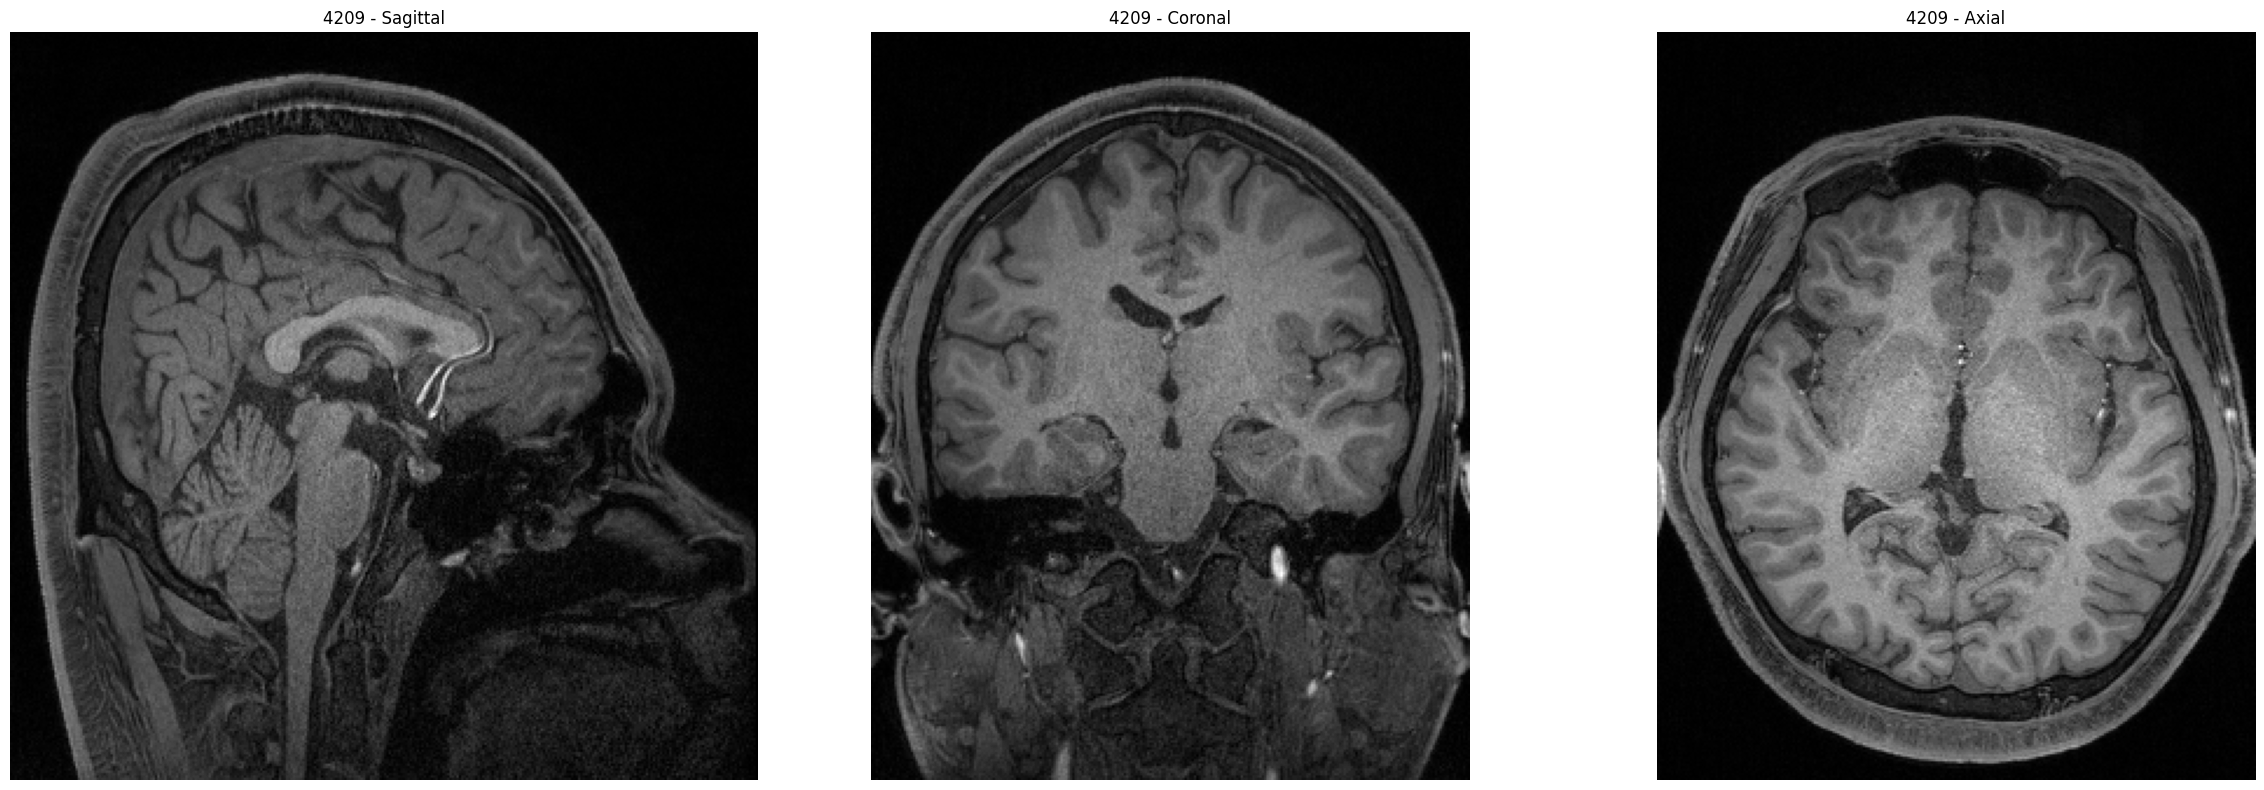

Adjusted centers (localizer → MPRAGE): [array([134.5674987 , 146.65663668, 169.18971998]), array([129.26504362, 151.95909177, 169.18971998]), array([129.26504362, 146.65663668, 174.49217507])]
Extracted rotation matrix for subject 4209:
[[-0.99990603  0.0106907  -0.0085819 ]
 [ 0.0085819   0.97629205  0.21628727]
 [-0.0106907  -0.2161933   0.97629205]]
Original unified_center: [129.26504362 146.65663668 169.18971998]
Rotated unified_center: [125.51466148 149.07203704 171.71777611]
Cropped (and padded) volume saved to: /mnt/hdd1/users/21011961_seok/MPRAGE_Cropped/4209_new.nii.gz


In [342]:
# --- Fixed parameters ---
localizer_voxel_size = 0.48828125  # Localizer voxel size (mm)
scale = 0.7
ref_localizer = np.array([256, 256, 256])  # Reference localizer voxel coordinate
ref_mprage = np.array([128, 160, 160])       # Reference MPRAGE coordinate (new volume center)

# --- Path settings ---
mprage_base_path_template = "/mnt/hdd1/users/21011961_seok/niix_Data_fMRS_local_struct/{}/T1_MPRAGE_ADNI_0002/"
localizer_base_path_template = "/mnt/hdd1/users/21011961_seok/niix_Data_fMRS_local_struct/{}/32CH_LOCALIZER_0001/"
# JSON file storing the 3D OBB information (center, size, angles) obtained from the localizer
predicted_boxes_path = "/mnt/hdd1/users/21011961_seok/pred_obb_3d.json"
# output_matrix_file: contains the affine matrix for rotation transformation (e.g., correction between localizer and MPRAGE)
output_matrix_file = "/mnt/hdd1/users/21011961_seok/output_matrix.json"

# --- Load predicted OBB info from localizer ---
with open(predicted_boxes_path, "r") as f:
    predicted_boxes = json.load(f)

# --- (Use the display_mprage_with_obb function from the previous code) ---
def display_mprage_with_obb(subject_id):
    localizer_folder_path = localizer_base_path_template.format(subject_id)
    mprage_folder_path = mprage_base_path_template.format(subject_id)
    
    localizer_files = sorted([
        os.path.join(localizer_folder_path, f)
        for f in os.listdir(localizer_folder_path)
        if f.endswith(".nii.gz")
    ])
    
    mprage_file_path = sorted([
        os.path.join(mprage_folder_path, f)
        for f in os.listdir(mprage_folder_path)
        if f.endswith(".nii.gz")
    ])[0]
    
    subject_info = predicted_boxes[subject_id]
    predicted_box_center_localizer = np.array(subject_info["center"])  # [x, y, z]
    predicted_box_size_localizer = np.array(subject_info["size"])      # [w, h, d]
    predicted_box_angles = np.array(subject_info["angles"])            # [angle_x, angle_y, angle_z] (in degrees)
    
    mprage_nii = nib.load(mprage_file_path)
    mprage_data = mprage_nii.get_fdata()
    mprage_affine = mprage_nii.affine
    mprage_center_voxel = np.array(mprage_data.shape) / 2.0
    mprage_center_physical = nib.affines.apply_affine(mprage_affine, mprage_center_voxel)
    
    localizer_center_physical_list = []
    for fp in localizer_files:
        nii = nib.as_closest_canonical(nib.load(fp))
        center_voxel = np.array(nii.shape) / 2.0
        center_phys = nib.affines.apply_affine(nii.affine, center_voxel)
        localizer_center_physical_list.append(center_phys)
    
    adjusted_centers = []
    for center_phys in localizer_center_physical_list:
        offset = mprage_center_physical - center_phys
        box_offset = (predicted_box_center_localizer - ref_localizer) * localizer_voxel_size - offset
        adjusted_center = box_offset / scale + ref_mprage
        adjusted_centers.append(adjusted_center)
    
    # Assuming there are two localizer datasets, combine them (example)
    unified_center = np.array([
        adjusted_centers[1][0],  # X: second localizer (coronal)
        adjusted_centers[0][1],  # Y: first localizer (sagittal)
        adjusted_centers[0][2]   # Z: first localizer (sagittal or coronal)
    ])
    
    predicted_box_size_mprage = (predicted_box_size_localizer * localizer_voxel_size) / scale
    
    # (Overlay code for display is omitted)
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    views = ["Sagittal", "Coronal", "Axial"]
    for i, view in enumerate(views):
        if view == "Sagittal":
            slice_index = int(unified_center[0])
            data = mprage_data[slice_index, :, :].T
        elif view == "Coronal":
            slice_index = int(unified_center[1])
            data = mprage_data[:, slice_index, :].T
        elif view == "Axial":
            slice_index = int(unified_center[2])
            data = mprage_data[:, :, slice_index].T
        axes[i].imshow(data, cmap="gray", origin="lower")
        axes[i].set_title(f"{subject_id} - {view}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
    
    print("Adjusted centers (localizer → MPRAGE):", adjusted_centers)
    return unified_center, predicted_box_size_mprage, predicted_box_angles, mprage_data, mprage_affine

# --- Additional: Code to apply rotation transformation based on output_matrix_file, crop the box region, and save the result ---
def crop_and_save_volume(subject_id, unified_center, predicted_box_size_mprage, mprage_data, mprage_affine, do_padding=True):
    # Load the affine matrix corresponding to the subject from output_matrix_file
    with open(output_matrix_file, "r") as f:
        output_matrix_dict = json.load(f)
    if subject_id in output_matrix_dict:
        subject_key = subject_id
    elif f"id_{subject_id}" in output_matrix_dict:
        subject_key = f"id_{subject_id}"
    else:
        raise ValueError(f"Subject {subject_id} not found in {output_matrix_file}.")
    
    affine_matrix = np.array(output_matrix_dict[subject_key])
    
    # Extract rotation and scaling components (using the extract_rotation_and_scaling function)
    def extract_rotation_and_scaling(affine_matrix):
        R_part = affine_matrix[:3, :3]
        U, S, Vt = np.linalg.svd(R_part)
        rotation_matrix = np.dot(U, Vt)
        return rotation_matrix, S
    rotation_matrix, _ = extract_rotation_and_scaling(affine_matrix)
    R_used = rotation_matrix
    print(f"Extracted rotation matrix for subject {subject_id}:\n{R_used}")
    
    full_shape = np.array(mprage_data.shape)
    full_center = (full_shape - 1) / 2.0
    
    # (1) Rotate the entire MPRAGE data (interpolation may slightly alter values)
    offset_full = full_center - R_used.dot(full_center)
    rotated_full = affine_transform(mprage_data, R_used, offset=offset_full,
                                    output_shape=tuple(mprage_data.shape), order=1)
    
    # (2) Create transformation matrix T to reflect the rotation transformation in mprage_affine
    T = np.eye(4)
    T[:3, :3] = R_used
    T[:3, 3] = full_center - R_used.dot(full_center)
    new_affine = mprage_affine @ T
    
    # (3) Apply the same rotation transformation to unified_center (based on data array coordinates)
    rotated_unified_center = R_used.dot(unified_center - full_center) + full_center
    print("Original unified_center:", unified_center)
    print("Rotated unified_center:", rotated_unified_center)
    
    # (4) Crop the predicted box region: calculated as an axis-aligned region
    crop_min = (rotated_unified_center - predicted_box_size_mprage / 2).astype(int)
    crop_max = (rotated_unified_center + predicted_box_size_mprage / 2).astype(int)
    crop_min = np.maximum(crop_min, 0)
    crop_max = np.minimum(crop_max, full_shape)
    
    cropped_vol = rotated_full[crop_min[0]:crop_max[0],
                                crop_min[1]:crop_max[1],
                                crop_min[2]:crop_max[2]]
    
    # (5) Optionally apply zero-padding (if do_padding=True, pad to a new volume size centered at ref_mprage)
    if do_padding:
        crop_shape = np.array(cropped_vol.shape)
        new_shape = np.array([256, 320, 320])  # Desired output volume size (example)
        # The new volume's center is ref_mprage
        insert_start = ref_mprage - (crop_shape // 2)
        insert_end = insert_start + crop_shape
        cropped_padded = np.zeros(new_shape, dtype=rotated_full.dtype)
        # Check boundary conditions (here, it is assumed that the crop region fully fits within the new volume)
        cropped_padded[insert_start[0]:insert_end[0],
                       insert_start[1]:insert_end[1],
                       insert_start[2]:insert_end[2]] = cropped_vol
        final_vol = cropped_padded
        final_shape = new_shape
    else:
        final_vol = cropped_vol
        final_shape = cropped_vol.shape
    
    # (6) Update the final affine: adjust so that the [0,0,0] of the new volume corresponds to crop_min of rotated_full
    new_affine_cropped = new_affine.copy()
    # If zero-padding is applied, consider insert_start in the update
    if do_padding:
        new_affine_cropped[:3, 3] = new_affine[:3, 3] + new_affine[:3, :3] @ (crop_min - insert_start)
    else:
        new_affine_cropped[:3, 3] = new_affine[:3, 3] + new_affine[:3, :3] @ crop_min
    
    # Output file path for saving (change as desired)
    output_file = f"/mnt/hdd1/users/21011961_seok/MPRAGE_Cropped/{subject_id}_new.nii.gz"
    cropped_nii = nib.Nifti1Image(final_vol, new_affine_cropped)
    nib.save(cropped_nii, output_file)
    print(f"Cropped (and padded) volume saved to: {output_file}")
    return final_vol, new_affine_cropped

if __name__ == "__main__":
    # Example: test subject id (change to desired subject id)
    subject_id = "4209"
    (unified_center_mprage,
     predicted_box_size_mprage,
     predicted_box_angles,
     mprage_data,
     mprage_affine) = display_mprage_with_obb(subject_id)
    
    # Crop and save the volume (choose whether to apply zero-padding using the do_padding parameter)
    cropped_vol, cropped_affine = crop_and_save_volume(subject_id, unified_center_mprage,
                                                       predicted_box_size_mprage, mprage_data,
                                                       mprage_affine, do_padding=True)